# General use of the lens equation solver

The notebook is a simple example of how to instantiate the Helens `LensEquationSolver` from an external mass profile model. Here we use Herculens to define that profile, but Helens can be combined with any other JAX-based modeling code.

__authors__: @aymgal

__last update__: 29/02/24

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none', origin='lower')
import numpy as np
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# Lens equation solver
from helens import LensEquationSolver

# Herculens (just as an example)
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.MassModel.mass_model import MassModel

/Users/aymgal/miniconda3/envs/herculens39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define the image plane coordinate grid

Here we use the `PixelGrid` class from Herculens as an example.

In [2]:
npix = 100  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2.
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2.  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
base_pixel_grid = PixelGrid(
    nx=npix, ny=npix,
    ra_at_xy_0=ra_at_xy_0, dec_at_xy_0=dec_at_xy_0,
    transform_pix2angle=transform_pix2angle,
)
# Optionally create a higher-resolution grid for the solver
solver_pixel_grid = base_pixel_grid.create_model_grid(pixel_scale_factor=0.5)

# Retrieve the pixel coordinates as 2D arrays
solver_grid_x, solver_grid_y = solver_pixel_grid.pixel_coordinates
print(solver_grid_x.shape)

(200, 200)


In [3]:
solver_grid_x, solver_grid_y

(array([[-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        ...,
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98],
        [-3.98, -3.94, -3.9 , ...,  3.9 ,  3.94,  3.98]]),
 array([[-3.98, -3.98, -3.98, ..., -3.98, -3.98, -3.98],
        [-3.94, -3.94, -3.94, ..., -3.94, -3.94, -3.94],
        [-3.9 , -3.9 , -3.9 , ..., -3.9 , -3.9 , -3.9 ],
        ...,
        [ 3.9 ,  3.9 ,  3.9 , ...,  3.9 ,  3.9 ,  3.9 ],
        [ 3.94,  3.94,  3.94, ...,  3.94,  3.94,  3.94],
        [ 3.98,  3.98,  3.98, ...,  3.98,  3.98,  3.98]]))

## Define the ray-tracing function from a given mass model

Here we use the `MassModel` class from Herculens as an example.

In [4]:
mass_model = MassModel(['EPL', 'SHEAR_GAMMA_PSI'])
some_lens_pos_x, some_lens_pos_y = 0.03, 0.02  # lens position
some_mass_params = [
    {'theta_E': 1.14, 'gamma': 1.92, 'e1': 0.01, 'e2': -0.09, 'center_x': some_lens_pos_x, 'center_y': some_lens_pos_y},  # EPL
    {'gamma_ext': 0.08, 'psi_ext': 1.2},  # SHEAR_GAMMA_PSI
]

def ray_shooting_func(theta_x, theta_y, params):
    """Function that computes evaluates the lens equation to return beta = theta - alpha(theta)"""
    beta_x, beta_y = mass_model.ray_shooting(theta_x, theta_y, params)
    return beta_x, beta_y

print(ray_shooting_func(0.1, 0.3, some_mass_params))

(Array(-0.21275129, dtype=float64, weak_type=True), Array(-0.71866541, dtype=float64, weak_type=True))


## Use the Helens solver

Initialize the solver and choose numerical settings

In [5]:
?LensEquationSolver

Init signature: LensEquationSolver(grid_x, grid_y, ray_shooting_func)
Docstring:     
Solver for the multiple lensed image positions of a source point.
The coordinates grid are assumed to be aligned with the image plane axis
(i.e., coordinates should define a rotated frame).

Parameters
----------
grid_x : array-like
    2D array containing the image plane x coordinates 
    used to search for multiple images.
grid_y : array-like
    2D array containing the image plane y coordinates 
    used to search for multiple images.
ray_shooting_func :
    Function that takes as input three arguments:
    - x coordinate (array or scalar),
    - y coordinate (array or scalar),
    - parameters of the lens mass model in the right format.
    The function should return the ray-shooted coordinates: 
    beta = theta - alpha(theta), where beta is the deflected source 
    coordinate of theta, and alpha is the deflection field.
File:           ~/Science/packages/my_packages/helens/helens/solver.py
Typ

In [6]:
solver = LensEquationSolver(solver_grid_x, solver_grid_y, ray_shooting_func)

Have a look at the hyperparameters of the solver

In [7]:
?LensEquationSolver.solve

Signature:
LensEquationSolver.solve(
    self,
    beta,
    lens_params,
    nsolutions=5,
    niter=5,
    scale_factor=2,
    nsubdivisions=1,
)
Docstring:
Solve the lens equation.

Parameters
----------
beta : jax array of shape (2,)
    Position of a point source in the source plane.
lens_params : dict or list or array
    Parameters defining the lens mass model, that are passed
    to the function `ray_shooting_func`.
nsolutions: int, optional
    Number of expected solutions (e.g. 5 for a quad including the
    central image)
niter : int
    Number of iterations of the solver.
scale_factor : float, optional
    Factor by which to scale the selected triangle areas at each iteration.
nsubdivisions : int, optional
    Number of times to subdivide (into 4) the selected triangles at
    each iteration.

Returns
-------
theta, beta : tuple of 2D jax arrays
    Image plane positions and their source plane counterparts are
    returned as arrays of shape (N, 2).
File:      ~/Science/pac

In [8]:

# Hyperparameters of the solver
solver_params = {
    # You have to specify the number of predicted images in advance
    'nsolutions': 5,

    # Hyperparameters (see docstring above)
    'niter': 5, 
    'scale_factor': 2, 
    'nsubdivisions': 3,
}

Based on your the grid resolution, you can obtain a rough estimate of the solver accuracy of the predicted positions in image plane. 

In [9]:
estim_acc = solver.estimate_accuracy(
    solver_params['niter'], 
    solver_params['scale_factor'], 
    solver_params['nsubdivisions']
)
print(f"Estimated accuracy in image plane (arcsec): {estim_acc:.2e}")

Estimated accuracy in image plane (arcsec): 6.91e-06


Call the solver and retrieve the predicted image positions

In [10]:
# Set the source position
some_beta_x, some_beta_y = -0.12, 0.15
some_beta = jnp.array([some_beta_x, some_beta_y])  # jnp.array is not absolutely necessary in this notebook

In [11]:
%%time
_ = solver.solve(
    some_beta, some_mass_params, 
    **solver_params
)  # takes some time to JIT-compile

CPU times: user 1.3 s, sys: 70.5 ms, total: 1.37 s
Wall time: 1.32 s


In [12]:
%%time
result_thetas, result_betas = solver.solve(
    some_beta, some_mass_params,
    **solver_params
)  # this is now very fast and differentiable!

CPU times: user 95.4 ms, sys: 31 ms, total: 126 ms
Wall time: 80.9 ms


In [13]:
# optionally convert the resulting JAX arrays to regular numpy arrays
result_thetas, result_betas = np.array(result_thetas), np.array(result_betas)

In [14]:
# unpack the results
result_theta_x, result_theta_y = result_thetas.T  # image plane positions
result_beta_x, result_beta_y = result_betas.T # corresponding source plane positions

Note that the central image will never be correctly mapped back to source plane, due to the cuspy nature of the deflection map. So we remove we ignore it in `result_betas_no_central`.

In [15]:
idx_central_img = np.argmin(np.hypot((result_theta_x-some_lens_pos_x), (result_theta_y-some_lens_pos_y)))  # just retrieving the closest image to the lens
result_beta_x_no_central = np.delete(result_beta_x, idx_central_img)
result_beta_y_no_central = np.delete(result_beta_y, idx_central_img)

## Visualize the results

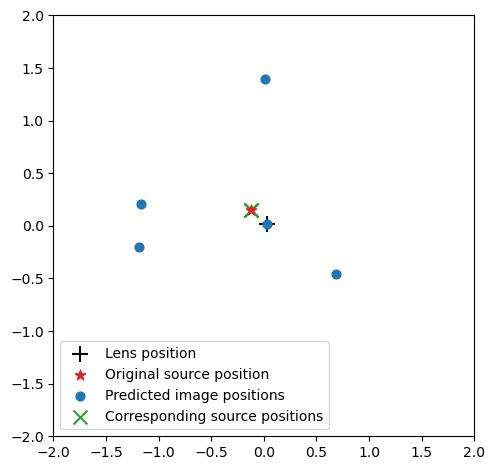

In [18]:
fig, axes = plt.subplots(1, 1)
ax = axes
ax.scatter(some_mass_params[0]['center_x'], some_mass_params[0]['center_y'], 
           c='black', s=120, marker='+', label="Lens position")
ax.scatter(some_beta_x, some_beta_y, c='tab:red', 
           s=60, marker='*', label="Original source position")
ax.scatter(result_theta_x, result_theta_y, c='tab:blue', 
           s=40, marker='o', label="Predicted image positions")
ax.scatter(result_beta_x_no_central, result_beta_y_no_central, c='tab:green',
           s=100, marker='x', label="Corresponding source positions", zorder=-1)
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.legend()
fig.tight_layout()
plt.show()

In [17]:
print("Original source position:", some_beta)
print("Mean over source positions:", (np.mean(result_beta_x_no_central), np.mean(result_beta_y_no_central)))

Original source position: [-0.12  0.15]
Mean over source positions: (-0.12000065597789873, 0.15000008059779527)
